In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from src.models.model_runner import ModelRunner
from src.models.evaluator import ModelEvaluator

# === Load & preprocess data ===
df = pd.read_csv("../data/2023_stock_with_features.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# Replace day names with integers: Monday=0, ..., Sunday=6
df['day_of_week'] = df['date'].dt.dayofweek

# === Create target: direction (up/down/neutral) based on next day's close ===
df['next_return'] = df.groupby('ticker')['close'].shift(-1) / df['close'] - 1

threshold = 0.001  # Can adjust (e.g., 0.001 for ignoring small movements)
df['direction'] = df['next_return'].apply(
    lambda x: 'up' if x > threshold else ('down' if x < -threshold else 'neutral')
)

df = df.dropna(subset=['direction'])

# === Train/test split ===
split_date = "2023-08-01"
train_df = df[df['date'] < split_date]
test_df = df[df['date'] >= split_date]

# === Feature selection ===
features = [
    'open', 'close', 'min', 'max', 'avg', 'quantity', 'volume',
    'ibovespa_close', 'day_of_week', 'daily_return', 'price_range', 'volume_per_quantity',
    'rolling_close_5', 'rolling_std_5', 'rolling_return_5', 'momentum_5', 'rolling_volume_5'
]

missing = [f for f in features if f not in df.columns]
if missing:
    raise ValueError(f"Missing features in dataframe: {missing}")

# Drop rows with NaNs introduced by rolling windows
df = df.dropna(subset=features + ['direction'])

X_train = train_df[features]
y_train = train_df['direction']
X_test = test_df[features]
y_test = test_df['direction']

# === Scale numeric features ===
scaler = StandardScaler()
cols_to_scale = [col for col in features if col != 'day_of_week']  # Don't scale day_of_week

X_train_scaled = X_train.copy()
X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train_scaled[cols_to_scale])

X_test_scaled = X_test.copy()
X_test_scaled[cols_to_scale] = scaler.transform(X_test_scaled[cols_to_scale])

# === Define classification models ===
models = [
    ModelRunner(LogisticRegression(max_iter=1000), name="LogisticRegression"),
    ModelRunner(make_pipeline(PolynomialFeatures(2), LogisticRegression(multi_class='multinomial', max_iter=1000)),
                name="PolynomialLogistic_deg2"),
    ModelRunner(make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, probability=True)), name="SVC_rbf"),
    ModelRunner(RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42), name="RandomForest"),
    ModelRunner(GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42),
                name="GradientBoosting")
]

# === Initialize evaluator ===
evaluator = ModelEvaluator(class_labels=['up', 'down', 'neutral'])

# === Evaluate models ===
for model in models:
    model.fit(X_train_scaled, y_train)
    evaluator.evaluate(model, X_test_scaled, y_test)

# === Initialize evaluator Train Data===
evaluator2 = ModelEvaluator(class_labels=['up', 'down', 'neutral'])

# === Evaluate models Train Data ===
for model in models:
    model.fit(X_train_scaled, y_train)
    evaluator2.evaluate(model, X_train_scaled, y_train)




Classification report for LogisticRegression:

              precision    recall  f1-score   support

          up       0.48      0.33      0.39       172
        down       0.00      0.00      0.00        28
     neutral       0.47      0.69      0.56       170

    accuracy                           0.47       370
   macro avg       0.32      0.34      0.32       370
weighted avg       0.44      0.47      0.44       370


Classification report for PolynomialLogistic_deg2:

              precision    recall  f1-score   support

          up       0.44      0.44      0.44       172
        down       0.00      0.00      0.00        28
     neutral       0.44      0.51      0.47       170

    accuracy                           0.44       370
   macro avg       0.29      0.32      0.30       370
weighted avg       0.41      0.44      0.42       370



/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Classification report for SVC_rbf:

              precision    recall  f1-score   support

          up       0.43      0.33      0.37       172
        down       0.00      0.00      0.00        28
     neutral       0.45      0.64      0.53       170

    accuracy                           0.45       370
   macro avg       0.29      0.32      0.30       370
weighted avg       0.41      0.45      0.42       370


Classification report for RandomForest:

              precision    recall  f1-score   support

          up       0.47      0.42      0.44       172
        down       0.00      0.00      0.00        28
     neutral       0.47      0.60      0.53       170

    accuracy                           0.47       370
   macro avg       0.31      0.34      0.32       370
weighted avg       0.43      0.47      0.45       370


Classification report for GradientBoosting:

              precision    recall  f1-score   support

          up       0.45      0.37      0.41       172
    

/home/anna/Escriptori/KDG/hackaton/lifecycleproject/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Classification report for SVC_rbf:

              precision    recall  f1-score   support

          up       0.65      0.56      0.60       325
        down       0.00      0.00      0.00        30
     neutral       0.61      0.74      0.67       345

    accuracy                           0.62       700
   macro avg       0.42      0.43      0.42       700
weighted avg       0.60      0.62      0.61       700


Classification report for RandomForest:

              precision    recall  f1-score   support

          up       0.98      1.00      0.99       325
        down       1.00      0.43      0.60        30
     neutral       0.97      1.00      0.98       345

    accuracy                           0.97       700
   macro avg       0.98      0.81      0.86       700
weighted avg       0.97      0.97      0.97       700


Classification report for GradientBoosting:

              precision    recall  f1-score   support

          up       1.00      1.00      1.00       325
    

In [4]:
# === Print results table ===
results_df = evaluator.get_results_dataframe()
print("\n=== Model Performance Summary ===")
print(results_df)


=== Model Performance Summary ===
                         accuracy  precision    recall        f1
model                                                           
LogisticRegression       0.470270   0.315042  0.339877  0.315857
RandomForest             0.470270   0.313545  0.339535  0.323403
GradientBoosting         0.456757   0.306167  0.329913  0.313083
SVC_rbf                  0.445946   0.294979  0.322253  0.300856
PolynomialLogistic_deg2  0.437838   0.292787  0.315937  0.303380


In [5]:
# === Print results table Train Data===
results_df = evaluator2.get_results_dataframe()
print("\n=== Model Performance Summary Train Data ===")
print(results_df)


=== Model Performance Summary Train Data ===
                         accuracy  precision    recall        f1
model                                                           
GradientBoosting         1.000000   1.000000  1.000000  1.000000
RandomForest             0.974286   0.982576  0.810145  0.858919
PolynomialLogistic_deg2  0.658571   0.771107  0.498536  0.523959
SVC_rbf                  0.624286   0.418479  0.433043  0.422695
LogisticRegression       0.552857   0.369615  0.382475  0.370532


=== Mutual Information Scores ===
                Feature  MutualInformation
7        ibovespa_close           0.157941
13        rolling_std_5           0.059836
12      rolling_close_5           0.042649
2                   min           0.028554
10          price_range           0.028293
15           momentum_5           0.023795
8           day_of_week           0.014554
6                volume           0.012470
11  volume_per_quantity           0.009892
4                   avg           0.008255
16     rolling_volume_5           0.006924
9          daily_return           0.003451
0                  open           0.000000
5              quantity           0.000000
3                   max           0.000000
1                 close           0.000000
14     rolling_return_5           0.000000


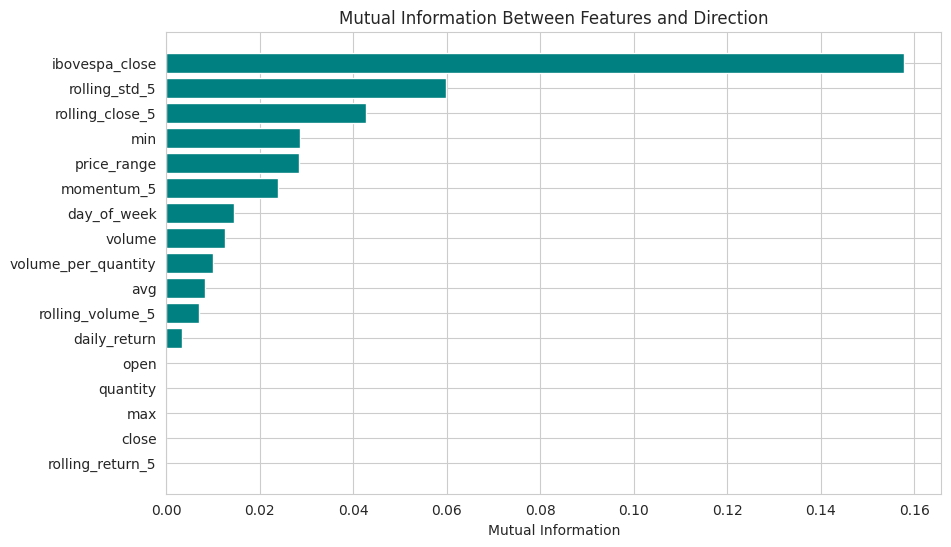

In [2]:
# # === Feature importances for tree-based models ===# === Initialize evaluator ===
evaluator = ModelEvaluator(class_labels=['up', 'down', 'neutral'])


from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

# Compute mutual information (non-parametric measure)
mi_scores = mutual_info_classif(X_train_scaled, y_train, discrete_features=False, random_state=42)

# Store in a DataFrame for better readability
mi_df = pd.DataFrame({
    'Feature': features,
    'MutualInformation': mi_scores
}).sort_values(by='MutualInformation', ascending=False)

print("=== Mutual Information Scores ===")
print(mi_df)

# Optional: visualize MI scores
plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['MutualInformation'], color='teal')
plt.gca().invert_yaxis()
plt.title("Mutual Information Between Features and Direction")
plt.xlabel("Mutual Information")
plt.show()

In [21]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)  # ['down','neutral','up'] → [0,1,2]
y_test_enc = le.transform(y_test)
# create model instance
# bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='multi:softmax')
bst = ModelRunner(XGBClassifier(
    n_estimators=500,
    max_depth=2,
    learning_rate=0.2,
    objective='multi:softprob',  # <-- key change
    num_class=3,                 # <-- must specify number of classes
    random_state=42
), name="XGBoost Classifier")


# fit model
bst.fit(X_train_scaled, y_train_enc)
# make predictions
preds = bst.predict(X_test_scaled)
print(preds)

evaluator.evaluate(bst,X_test_scaled, y_test_enc)

[2 2 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 2 0 2 2 0 0 2 2 0 2 2 0 0 2 0 2 2 2
 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 0 2 0 2 2 2 2 0 2 0 2 0 2 2 2 2 0 0 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 2 2 0 0 0 0 2 0 2 0 2 2
 2 2 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 0 2 0 0 2
 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 2 2 0 0 0 0 2 2 2 2 0 0 0 0 0 2 2 2 2 2 2
 2 0 0 2 2 2 2 2 2 2 2 0 2 0 2 2 0 0 2 2 0 2 2 2 0 0 2 2 1 0 2 2 2 2 2 2 0
 2 2 2 2 0 0 2 2 2 2 0 0 2 0 0 0 0 0 1 2 2 2 2 0 1 2 2 2 0 2 0 2 2 0 2 2 2
 2 2 2 2 2 0 2 2 2 1 2 2 0 0 0 2 0 0 0 0 2 0 2 2 2 0 2 2 2 0 2 0 0 2 0 2 2
 0 0 2 2 2 2 0 2 0 2 0 2 0 0 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 2 2 0 2 1 2 0 0
 2 0 0 0 0 0 0 0 2 0 2 2 0 0 0 0 0 2 2 0 0 0 2 2 0 2 2 0 0 0 0 0 0 0 0 0 0]

Classification report for XGBoost Classifier:

              precision    recall  f1-score   support

          up       0.48      0.39      0.43       172
        down       0.20      0.04      0.06        28
     neutral       0.48      0.64     